In [19]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models.convnext import ConvNeXt
from torchvision import transforms
from torchvision.datasets import GTSRB

# Setting

In [20]:
IMAGE_SIZE = 256
BATCH_SIZE = 64

In [21]:
artifact_path = Path("../../artifacts/convnext")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/gtsrb")

In [22]:
DEVICE = torch.device("cuda:0")

# data

In [23]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.1,
        ),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [24]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [25]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [26]:
num_class = 43

In [27]:
len(train_dataset)

26640

2


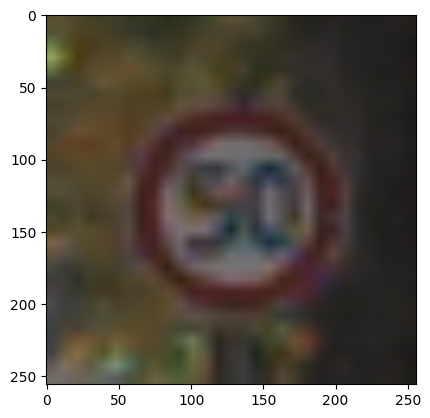

In [28]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [29]:
model = ConvNeXt(output_size=num_class, size="tiny").to(DEVICE)

In [30]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
ConvNeXt                                      --
├─Sequential: 1-1                             --
│    └─Conv2d: 2-1                            4,704
│    └─GroupNorm: 2-2                         192
├─Sequential: 1-2                             --
│    └─ResBlock: 2-3                          --
│    │    └─BottleNeck: 3-1                   79,200
│    │    └─Identity: 3-2                     --
│    └─ResBlock: 2-4                          --
│    │    └─BottleNeck: 3-3                   79,200
│    │    └─Identity: 3-4                     --
│    └─ResBlock: 2-5                          --
│    │    └─BottleNeck: 3-5                   79,200
│    │    └─Identity: 3-6                     --
│    └─GroupNorm: 2-6                         192
│    └─Conv2d: 2-7                            73,920
│    └─ResBlock: 2-8                          --
│    │    └─BottleNeck: 3-7                   305,856
│    │    └─Identity: 3-8             

# training

In [ ]:
EPOCH = 10
acc_iters = 256 / BATCH_SIZE

In [32]:
trainer = ClassificationTrainer(EPOCH, DEVICE, acc_iters)
trainer.recorder.increment_data_size(len(train_dataset))

In [ ]:
criterion = trainer.get_criterion(num_class, label_smoothing=0)
optim = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

In [ ]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim, T_0=10, T_mult=2)

In [35]:
scaler = torch.cuda.amp.GradScaler()

In [36]:
training_loss = trainer.run(
    train_loader,
    model,
    optim,
    criterion,
    scheduler=scheduler,
    scaler=scaler,
)

Enable AMP: True
Training...


100%|██████████| 416/416 [02:40<00:00,  2.60it/s]


------------------------------------
Epoch 1
------------------------------------
0.014389426590086104 (0%)


100%|██████████| 416/416 [02:37<00:00,  2.64it/s]


------------------------------------
Epoch 2
------------------------------------
0.013776855134928186 (-4%)


100%|██████████| 416/416 [02:37<00:00,  2.64it/s]


------------------------------------
Epoch 3
------------------------------------
0.01290660066916062 (-6%)


100%|██████████| 416/416 [02:37<00:00,  2.64it/s]


------------------------------------
Epoch 4
------------------------------------
0.006898159855926364 (-47%)


100%|██████████| 416/416 [02:37<00:00,  2.63it/s]


------------------------------------
Epoch 5
------------------------------------
0.003963016177731772 (-43%)


100%|██████████| 416/416 [02:36<00:00,  2.65it/s]


------------------------------------
Epoch 6
------------------------------------
0.0031534127203059633 (-20%)


100%|██████████| 416/416 [02:36<00:00,  2.65it/s]


------------------------------------
Epoch 7
------------------------------------
0.0029339581129473953 (-7%)


100%|██████████| 416/416 [02:37<00:00,  2.65it/s]


------------------------------------
Epoch 8
------------------------------------
0.002829782200512945 (-4%)


100%|██████████| 416/416 [02:39<00:00,  2.62it/s]


------------------------------------
Epoch 9
------------------------------------
0.002781674090784053 (-2%)


100%|██████████| 416/416 [02:39<00:00,  2.61it/s]

------------------------------------
Epoch 10
------------------------------------
0.0028055429682359305 (1%)


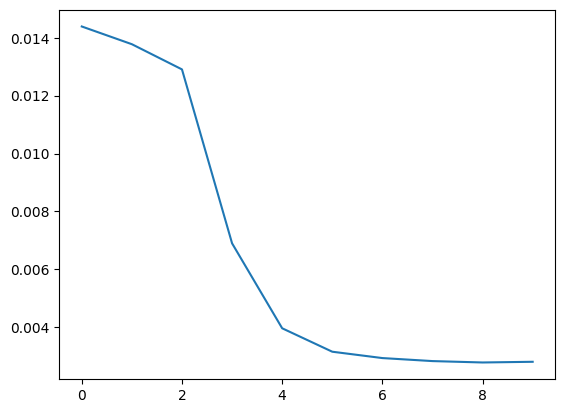

In [37]:
plt.plot(training_loss)

# inference

In [38]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [39]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [40]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [41]:
evaluator = ClassificationEvaluator(num_class, DEVICE)

In [42]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 198/198 [00:41<00:00,  4.81it/s]

[[ 55   1   0 ...   0   0   0]
 [  0 717   1 ...   0   0   0]
 [  0   4 742 ...   0   0   0]
 ...
 [  0   0   0 ...  83   0   0]
 [  0   0   0 ...   0  40   0]
 [  0   0   0 ...   0   6  79]]


In [43]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(num_class), per_class_acc)

0         : 0.9166666666666666
1         : 0.9958333333333333
2         : 0.9893333333333333
3         : 0.92
4         : 0.9757575757575757
5         : 0.9650793650793651
6         : 0.8133333333333334
7         : 0.94
8         : 0.94
9         : 1.0
10        : 0.9818181818181818
11        : 0.9428571428571428
12        : 1.0
13        : 0.9944444444444445
14        : 0.9851851851851852
15        : 0.9571428571428572
16        : 1.0
17        : 1.0
18        : 0.7974358974358975
19        : 0.55
20        : 0.9777777777777777
21        : 0.6555555555555556
22        : 0.95
23        : 0.9866666666666667
24        : 0.9444444444444444
25        : 0.9708333333333333
26        : 0.9777777777777777
27        : 0.6166666666666667
28        : 0.92
29        : 1.0
30        : 0.9
31        : 0.9592592592592593
32        : 1.0
33        : 0.8523809523809524
34        : 0.875
35        : 1.0
36        : 0.775
37        : 0.8333333333333334
38        : 0.9434782608695652
39        : 0.1666666

In [44]:
per_class_acc.mean()

0.8938696436694414

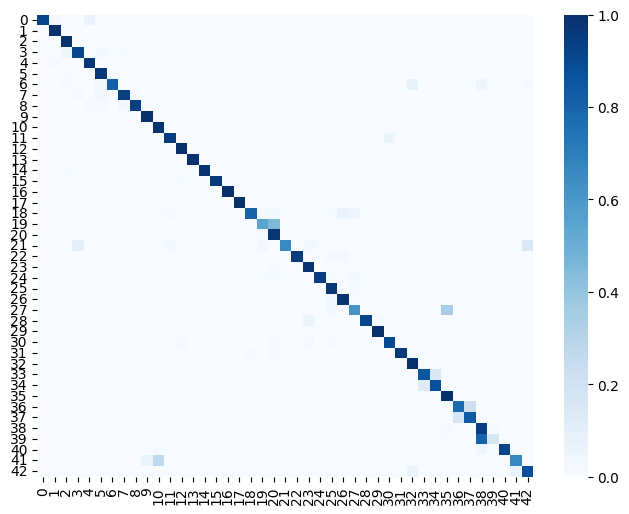

In [45]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(num_class),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [46]:
model_path = artifact_path / f'convnext.pth'

In [47]:
torch.save(model.state_dict(), model_path)

In [48]:
get_file_size(model_path)

'106.28MiB'

In [49]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>